# Exploratory Analysis

This notebook contains steps and decisions made in the second iteration of exploring the Austin crime data.

## The Required Imports

Here we'll import all the modules required to run the code cells in this notebook.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from scipy import stats

from wrangle import *
from prepare import split_data
from explore import *

## Acquire and Prepare Data

Here we'll acquire and prepare the data using the wrangle module.

In [2]:
# We'll need to explictly drop all cleared by exception rows.

df = wrangle_crime_data(drop_cleared_by_exception = True)
df.shape

Using cached csv


(348008, 19)

## Split the Data

Now we will need to split the data before we begin exploring because we will now begin exploring the relationship between the target variable and other features in the data.

In [3]:
train, validate, test = split_data(df, 'cleared')
train.shape, validate.shape, test.shape

((194884, 19), (83522, 19), (69602, 19))

From here on we'll only use the train variable.

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194884 entries, 226391 to 212383
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype          
---  ------             --------------   -----          
 0   crime_type         194884 non-null  object         
 1   family_violence    194884 non-null  object         
 2   occurrence_time    194884 non-null  datetime64[ns] 
 3   occurrence_date    194884 non-null  datetime64[ns] 
 4   report_time        194884 non-null  datetime64[ns] 
 5   report_date        194884 non-null  datetime64[ns] 
 6   location_type      194884 non-null  object         
 7   address            194884 non-null  object         
 8   zip_code           194884 non-null  float64        
 9   council_district   194884 non-null  float64        
 10  sector             194884 non-null  object         
 11  district           194884 non-null  object         
 12  latitude           194884 non-null  float64        
 13  longitude          19488

## At what response time does clearance rate drop off significantly?

In [5]:
# Here we'll look at the difference in clearance rate between observations with time_to_report less than n hours and 
# observations with time_to_report greater than n hours where n is in the range 0 - 24 hours.

for hour in range(25):
    print(
        f'{hour}: ',
        train[train.time_to_report <= pd.Timedelta(f'{hour}h')].cleared.mean(),
        train[train.time_to_report > pd.Timedelta(f'{hour}h')].cleared.mean()
    )

0:  0.351670061599627 0.10496516447658524
1:  0.33394429284868454 0.08315519234113063
2:  0.33046267205266305 0.05935865362747328
3:  0.3276453841582929 0.044051576140555944
4:  0.32420819718527283 0.03523114852522259
5:  0.3206581045916226 0.031166671066874357
6:  0.31746976498111085 0.029182168707298926
7:  0.31430436556507546 0.028243979318162967
8:  0.3113615462803117 0.027692394461521108
9:  0.3080736826163546 0.027525314358966973
10:  0.30481687678654396 0.02727821719470343
11:  0.30125923047026815 0.027236766615333516
12:  0.29746006206183195 0.027000574810856156
13:  0.29339497420736677 0.026618289237092217
14:  0.2894852192777171 0.026475125657316325
15:  0.2853110649624148 0.0265448665015139
16:  0.2814390665514261 0.026514881164799088
17:  0.2779154037804956 0.02607262559487436
18:  0.27483831185666335 0.025646431925782524
19:  0.2722782907451149 0.02480353148445078
20:  0.2699097443212992 0.02457412992093895
21:  0.267878754912493 0.024325454925747753
22:  0.266113360323886

In [6]:
# Now let's put these results in a line chart.

clearance_rates = [train[train.time_to_report <= pd.Timedelta(f'{hour}h')].cleared.mean() for hour in range(7 * 24 + 1)]

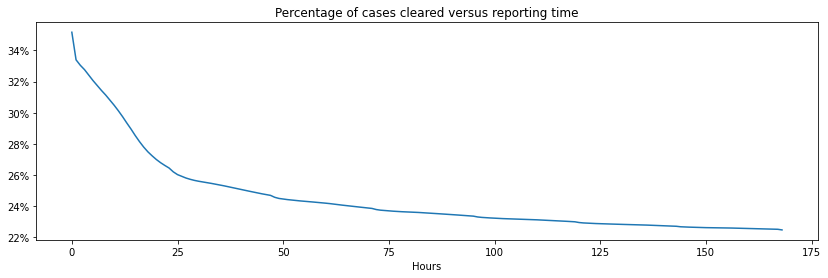

In [7]:
plt.figure(figsize = (14, 4))
temp = pd.DataFrame({'clearance_rate' : clearance_rates})

ax = sns.lineplot(data = temp, y = 'clearance_rate', x = temp.index)

plt.xlabel('Hours')
plt.ylabel('')

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 0))

plt.title('Percentage of cases cleared versus reporting time');

In [8]:
train['time_to_report_bins'] = pd.cut(
    train.time_to_report,
    [
        pd.Timedelta('-1d'),
        pd.Timedelta('24h'),
        pd.Timedelta('10y')
    ],
    labels = [
        'Less than 24 hours',
        'Greater than 24 hours'
    ]
)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


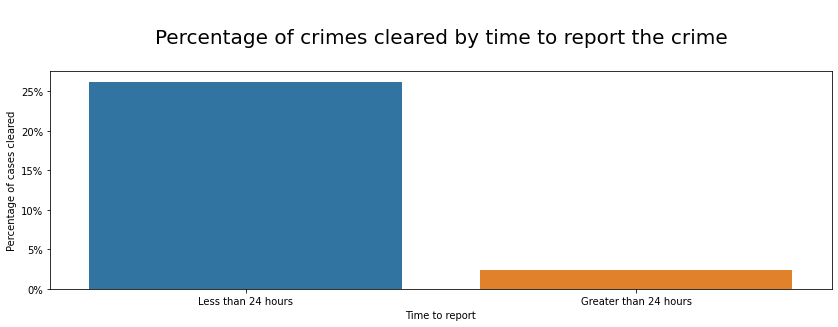

In [14]:
plt.figure(figsize = (14, 4))

ax = sns.barplot(
    data = train,
    x = 'time_to_report_bins',
    y = 'cleared',
    ci = None
)

plt.xlabel('Time to report')
plt.ylabel('Percentage of cases cleared')

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 0))

title = '''
Percentage of crimes cleared by time to report the crime
'''
plt.title(title, fontsize = 20);

## How does type of crime affect the dependency between clearance status and time to report?

I'm interested to know for which crime types is there no significant difference in clearance rate between crimes with a report time less than 24 hours and crimes with a report time greater than 24 hours.

In [10]:
# Here we're going to run a t-test for each crime type testing the following hypothesis:
# H0: The average number of cases cleared for cases with time to report less than 24 hours is equal 
# to the average number of cases cleared for cases with time to report greater than 24 hours.

# We'll keep a list of all crime types where p is not less than alpha meaning the null hypothesis could not 
# be rejected.
# We'll only look at crime types with at least 30 observations and assume non equal variance for simplicity.

alpha = 0.05
types = []

time_to_report_less_than_24hrs = train.time_to_report <= pd.Timedelta('24h')
time_to_report_greater_than_24hrs = train.time_to_report > pd.Timedelta('24h')

for crime in train.crime_type.unique():
    subset = train[train.crime_type == crime]
    
    if train[train.crime_type == crime].cleared.count() > 100 and train[train.crime_type == crime].cleared.mean() < 0.5:
        t, p = stats.ttest_ind(
            subset[time_to_report_less_than_24hrs].cleared,
            subset[time_to_report_greater_than_24hrs].cleared,
            alternative = 'greater',
            equal_var = False
        )
        if p >= alpha:
            types.append(crime)

/var/folders/45/z3vf0vrn1fz5mzs6sp418wym0000gn/T/ipykernel_2011/3647183039.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset[time_to_report_less_than_24hrs].cleared,
/var/folders/45/z3vf0vrn1fz5mzs6sp418wym0000gn/T/ipykernel_2011/3647183039.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset[time_to_report_greater_than_24hrs].cleared,
/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [11]:
len(types)

23

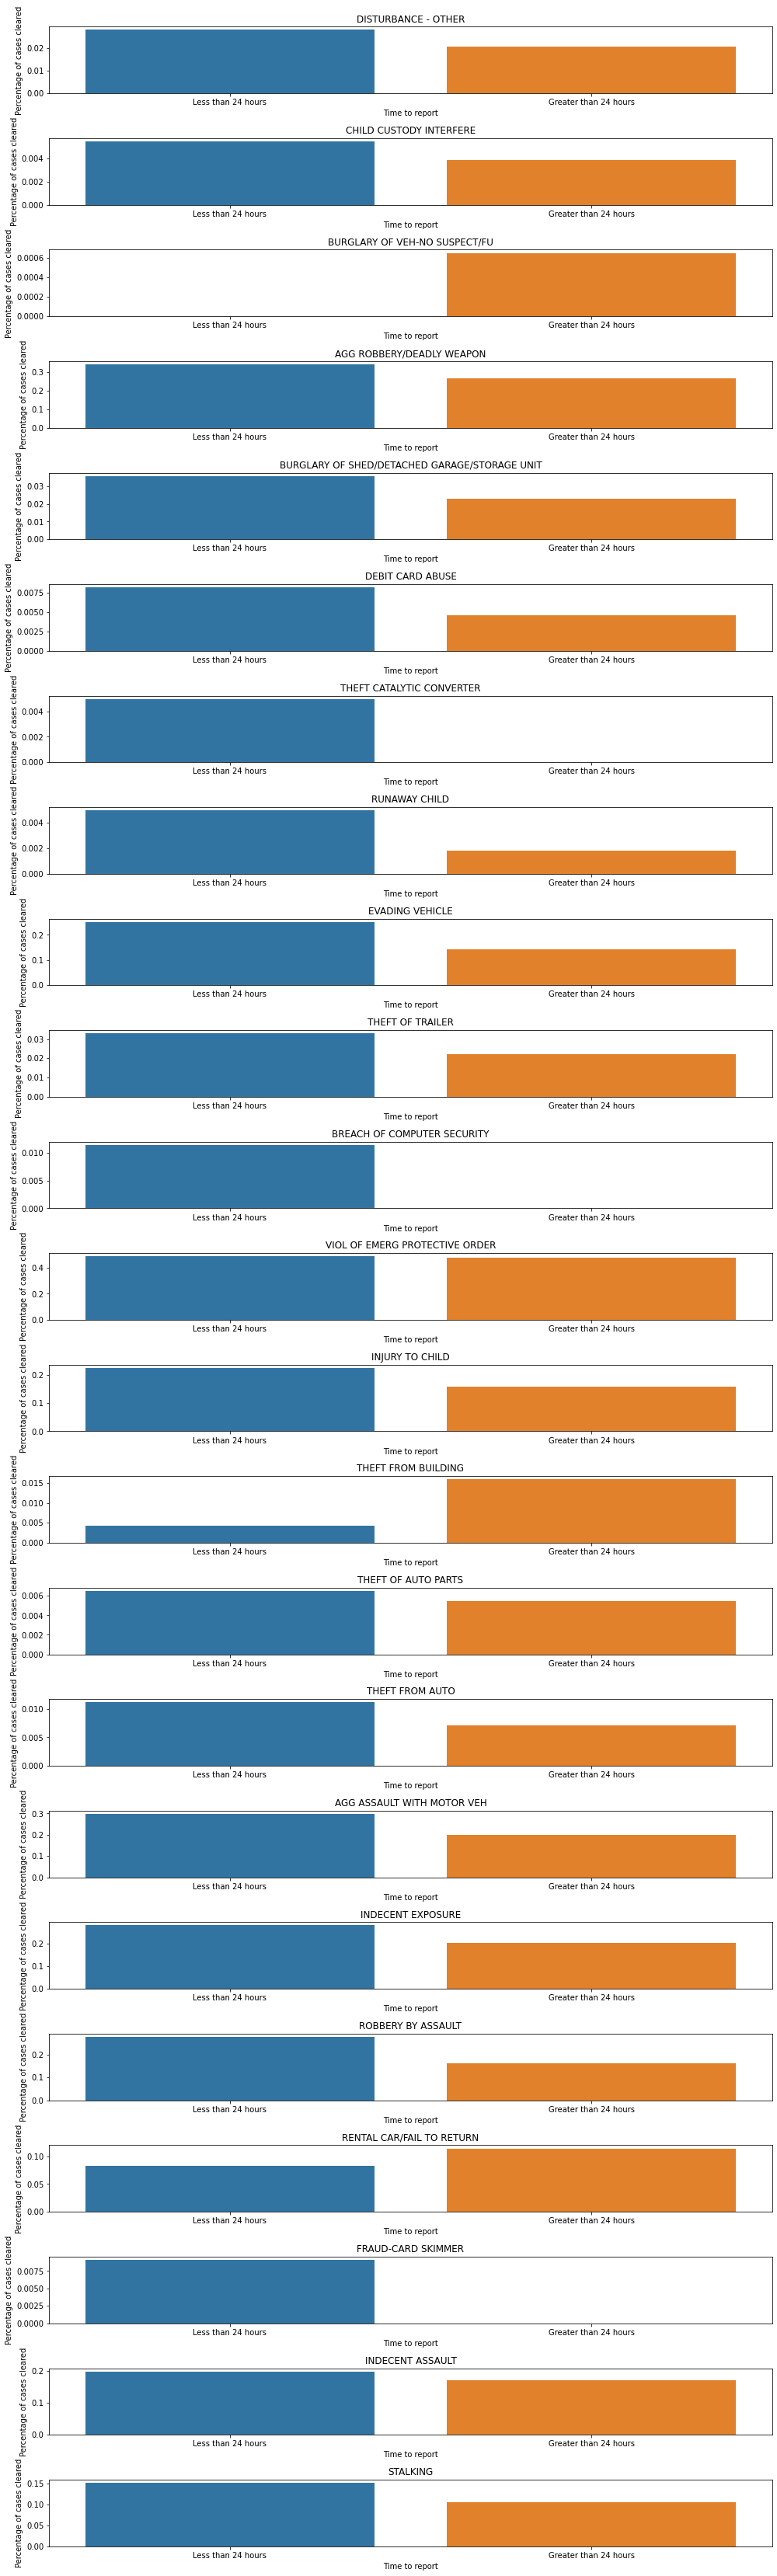

In [12]:
fig, ax = plt.subplots(nrows = len(types), ncols = 1, figsize = (14, 2 * len(types)))

for index, crime_type in enumerate(types):
    sns.barplot(
        data = train[train.crime_type == crime_type],
        x = 'time_to_report_bins',
        y = 'cleared',
        ci = None,
        ax = ax[index]
    )

    ax[index].set_xlabel('Time to report')
    ax[index].set_ylabel('Percentage of cases cleared')

    ax[index].set_title(crime_type)
    
plt.tight_layout();

In [13]:
sorted(types)

['AGG ASSAULT WITH MOTOR VEH',
 'AGG ROBBERY/DEADLY WEAPON',
 'BREACH OF COMPUTER SECURITY',
 'BURGLARY OF SHED/DETACHED GARAGE/STORAGE UNIT',
 'BURGLARY OF VEH-NO SUSPECT/FU',
 'CHILD CUSTODY INTERFERE',
 'DEBIT CARD ABUSE',
 'DISTURBANCE - OTHER',
 'EVADING VEHICLE',
 'FRAUD-CARD SKIMMER',
 'INDECENT ASSAULT',
 'INDECENT EXPOSURE',
 'INJURY TO CHILD',
 'RENTAL CAR/FAIL TO RETURN',
 'ROBBERY BY ASSAULT',
 'RUNAWAY CHILD',
 'STALKING',
 'THEFT CATALYTIC CONVERTER',
 'THEFT FROM AUTO',
 'THEFT FROM BUILDING',
 'THEFT OF AUTO PARTS',
 'THEFT OF TRAILER',
 'VIOL OF EMERG PROTECTIVE ORDER']

### Takeaways

This list of crime types are all crimes with at least 100 observations where the reporting time does not make a significant difference in clearance rate. There are a few ways to interpret this. These can either be crimes that are generally unsolvable, or at least unclearable. Otherwise, we can look at these crimes as areas of improvement since reporting time doesn't seem to make a difference in the solvability of these crimes.

## Clearance Date

In [14]:
train[train.cleared == False].head()

,crime_type,family_violence,occurrence_time,occurrence_date,report_time,report_date,location_type,address,zip_code,council_district,sector,district,latitude,longitude,clearance_status,clearance_date,cleared,time_to_report,pandemic_lockdown,time_to_report_bins
266878,FAMILY DISTURBANCE,N,2019-08-23 19:13:00,2019-08-23,2019-08-23 19:13:00,2019-08-23,RESIDENCE / HOME,907 AIROSO CV,78745.0,2.0,FR,4,30.206636,-97.787635,not cleared,2020-03-10,False,0 days 00:00:00,False,Less than 24 hours
187102,FRAUD - OTHER,N,2020-05-29 13:00:00,2020-05-29,2020-05-29 15:16:00,2020-05-29,RESTAURANT,10515 N MOPAC EXPY SVRD NB,78759.0,7.0,AD,1,30.391604,-97.732448,not cleared,2020-06-15,False,0 days 02:16:00,True,Less than 24 hours
285600,FAMILY DISTURBANCE,N,2019-06-22 03:54:00,2019-06-22,2019-06-22 03:54:00,2019-06-22,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,E 11TH ST / RED RIVER ST,78701.0,1.0,GE,1,30.271169,-97.735451,not cleared,2019-08-30,False,0 days 00:00:00,False,Less than 24 hours
425648,FAMILY DISTURBANCE/PARENTAL,N,2018-02-11 22:33:00,2018-02-11,2018-02-11 22:56:00,2018-02-11,RESIDENCE / HOME,5701 MAGEE BND,78749.0,8.0,DA,7,30.210902,-97.869193,not cleared,2018-02-26,False,0 days 00:23:00,False,Less than 24 hours
249937,IDENTITY THEFT,N,2019-10-18 20:40:00,2019-10-18,2021-06-22 20:59:00,2021-06-22,RESIDENCE / HOME,7685 NORTHCROSS DR,78757.0,7.0,BA,6,30.354218,-97.735698,not cleared,2021-06-30,False,613 days 00:19:00,False,Greater than 24 hours


Even for crimes that are not cleared there is a clearance date. This would definitely require more context to understand.

## Multivariate Analysis With Crime Types

Let's look at how the crime types vary with different variables.

In [15]:
# We'll use the merged dataframe for this analysis.

df = wrangle_merged_df(drop_columns = True)
train, validate, test = split_data(df)

Using cached csv


In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197640 entries, 17761 to 50448
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype          
---  ------             --------------   -----          
 0   crime_type         197640 non-null  object         
 1   family_violence    197640 non-null  object         
 2   occurrence_time    197640 non-null  datetime64[ns] 
 3   occurrence_date    197640 non-null  datetime64[ns] 
 4   report_time        197640 non-null  datetime64[ns] 
 5   report_date        197640 non-null  datetime64[ns] 
 6   location_type      197640 non-null  object         
 7   address            197640 non-null  object         
 8   zip_code           197640 non-null  float64        
 9   council_district   197640 non-null  float64        
 10  sector             197640 non-null  object         
 11  latitude           197640 non-null  float64        
 12  longitude          197640 non-null  float64        
 13  clearance_status   197640 

In [17]:
train['time_to_report_bins'] = pd.cut(
    train.time_to_report,
    [
        pd.Timedelta('-1d'),
        pd.Timedelta('24h'),
        pd.Timedelta('10y')
    ],
    labels = [
        'Less than 24 hours',
        'Greater than 24 hours'
    ]
)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


### pd_district

In [18]:
train.district_name.value_counts()

EDWARD 1    8246
HENRY 2     7290
GEORGE 2    6180
EDWARD 2    5571
DAVID 1     5492
            ... 
EDWARD 5    1016
HENRY 6      897
GEORGE 4     785
DAVID 8      733
EDWARD 8     112
Name: district_name, Length: 68, dtype: int64

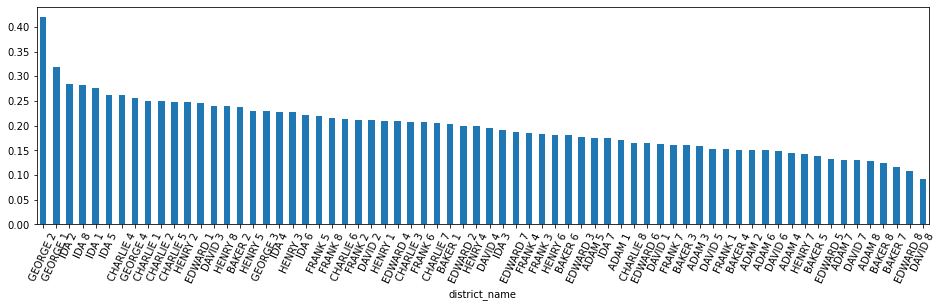

In [19]:
train.groupby('district_name').cleared.mean().sort_values(ascending = False).plot.bar(figsize = (16, 4))

plt.xticks(rotation = 65);

In [20]:
train[train.patrol_area == 'DTAC'].district_name.unique()

array(['GEORGE 2', 'GEORGE 1', 'GEORGE 4', 'GEORGE 3'], dtype=object)

### patrol_area

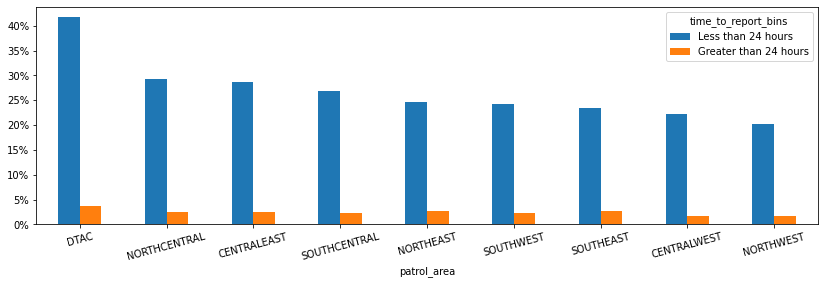

In [21]:
ax = (
    train.groupby(['patrol_area', 'time_to_report_bins'])
    .cleared
    .mean()
    .unstack()
    .sort_values(by = 'Less than 24 hours', ascending = False)
    .plot.bar(figsize = (14, 4))
)

plt.xticks(rotation = 15)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 0));

In [22]:
# Due to the large number of crime type categories, for exploration purposes we'll use only the top
# 10 crime categories.

top_10_crimes = [
    'DWI',
    'ASSAULT WITH INJURY',
    'THEFT BY SHOPLIFTING',
    'HARASSMENT',
    'AUTO THEFT',
    'ASSAULT W/INJURY-FAM/DATE VIOL',
    'CRIMINAL MISCHIEF',
    'FAMILY DISTURBANCE',
    'THEFT',
    'BURGLARY OF VEHICLE'
]

# Create a subsetted df that only includes the top 10 crimes
top_crimes_df = train.copy()
top_crimes_df = top_crimes_df[top_crimes_df.crime_type.isin(top_10_crimes)]

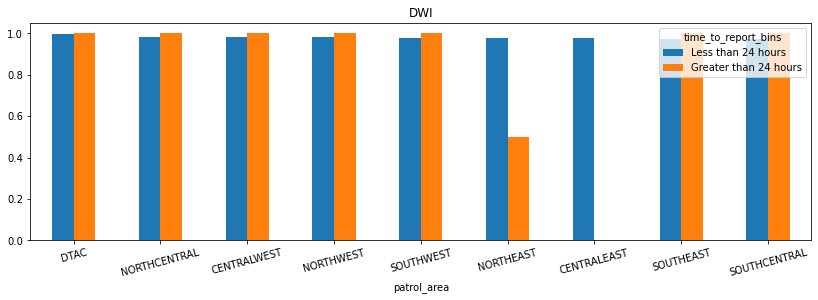

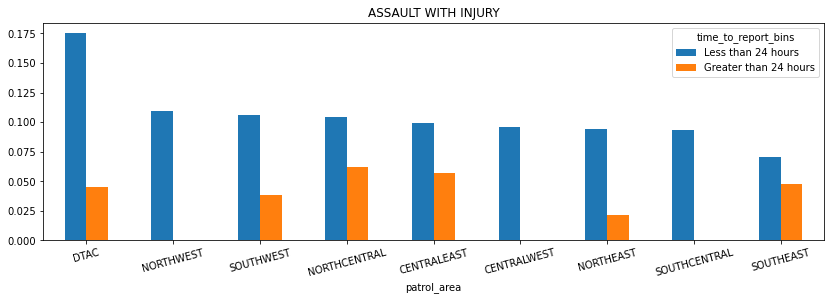

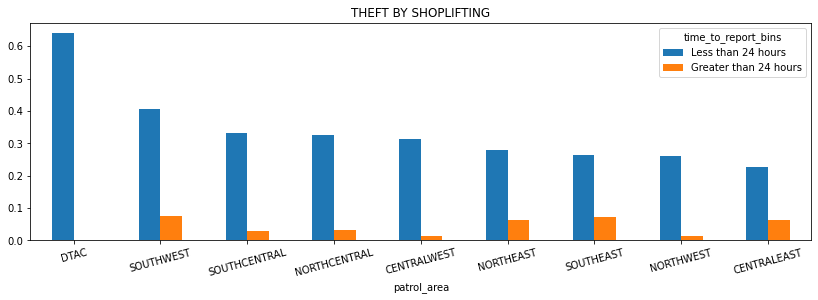

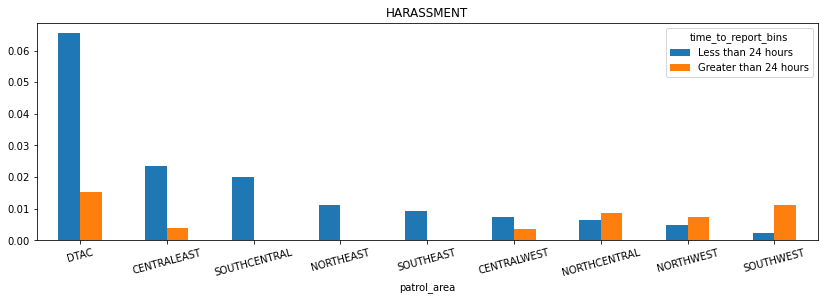

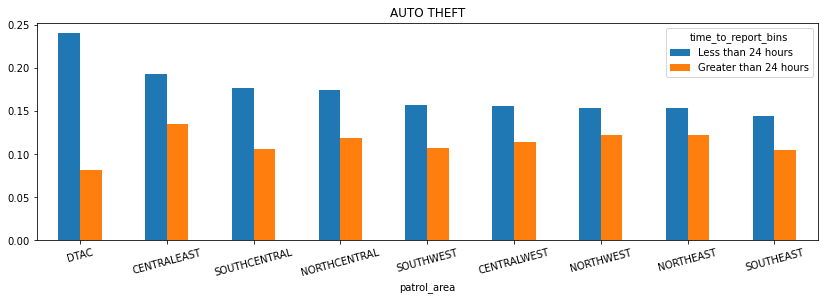

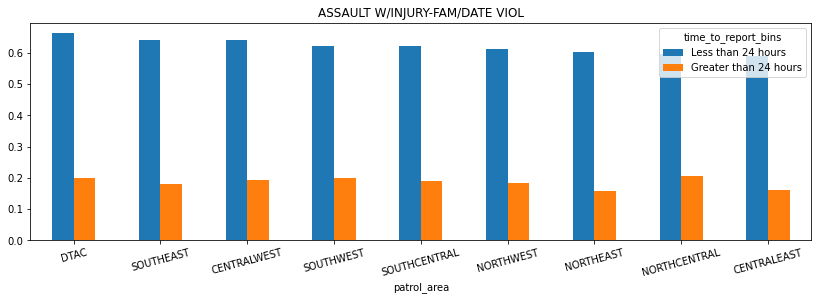

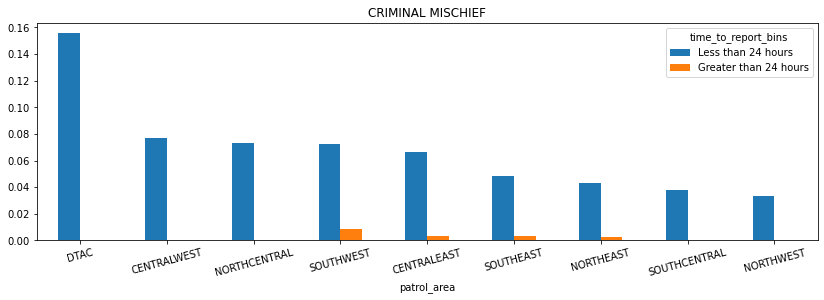

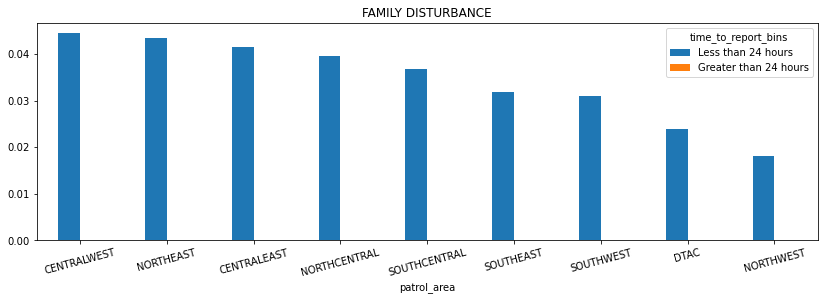

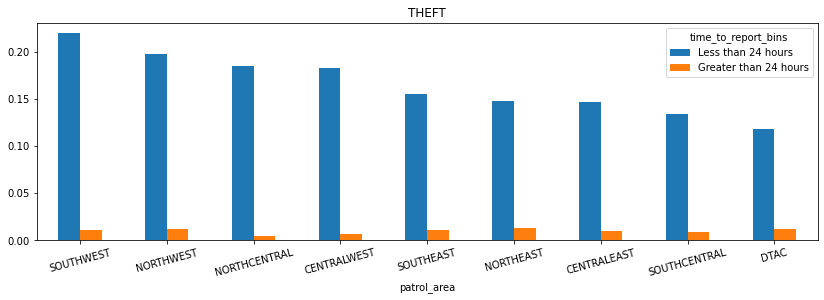

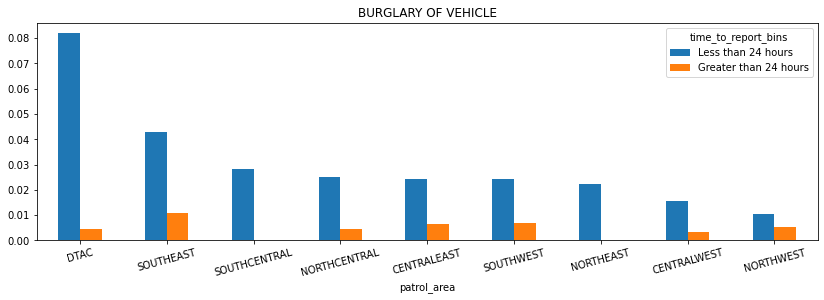

In [23]:
for crime in top_10_crimes:
    (
        train[train.crime_type == crime].groupby(['patrol_area', 'time_to_report_bins'])
        .cleared
        .mean()
        .unstack()
        .sort_values(by = 'Less than 24 hours', ascending = False)
        .plot.bar(figsize = (14, 4))
    )
    
    plt.title(crime)

    plt.xticks(rotation = 15)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 0))
    
    plt.show()

In [24]:
train.groupby('patrol_area').time_to_report.mean().sort_values()

patrol_area
DTAC           3 days 12:48:25.840809003
NORTHEAST      4 days 04:35:07.822719449
NORTHCENTRAL   4 days 11:22:53.900602409
SOUTHCENTRAL   4 days 11:53:02.835660580
CENTRALEAST    4 days 17:52:21.965048912
SOUTHEAST      5 days 15:36:36.012658227
SOUTHWEST      5 days 23:27:11.403180169
NORTHWEST      6 days 00:17:38.633323392
CENTRALWEST    6 days 03:21:54.752753802
Name: time_to_report, dtype: timedelta64[ns]

In [25]:
train[train.time_to_report <= pd.Timedelta('1d')].groupby('patrol_area').time_to_report.mean().sort_values()

patrol_area
DTAC           0 days 02:42:39.437806072
CENTRALEAST    0 days 02:52:08.093914483
NORTHCENTRAL   0 days 03:00:17.946596464
SOUTHCENTRAL   0 days 03:00:25.954454481
SOUTHEAST      0 days 03:02:27.998272511
NORTHEAST      0 days 03:05:26.634094341
SOUTHWEST      0 days 03:58:03.750813272
NORTHWEST      0 days 04:07:07.011574886
CENTRALWEST    0 days 04:45:29.970093706
Name: time_to_report, dtype: timedelta64[ns]

## Location Type Analysis

Let's do some analysis on location types. We're interested in knowing which types of locations typically see higher levels of crime and what the clearance rate for those location types are.

In [26]:
train.location_type.value_counts(normalize = True)

RESIDENCE / HOME                                   0.404893
HWY / ROAD / ALLEY/ STREET/ SIDEWALK               0.168159
PARKING /DROP LOT/ GARAGE                          0.128648
OTHER / UNKNOWN                                    0.074135
COMMERCIAL / OFFICE BUILDING                       0.027732
HOTEL / MOTEL / ETC.                               0.022273
DEPARTMENT / DISCOUNT STORE                        0.021661
RESTAURANT                                         0.020325
GROCERY / SUPERMARKET                              0.017370
CONVENIENCE STORE                                  0.015660
SERVICE/ GAS STATION                               0.014445
DRUG STORE / DOCTOR'S OFFICE / HOSPITAL            0.011556
BAR / NIGHTCLUB                                    0.011182
PARK / PLAYGROUND                                  0.008698
SPECIALTY  STORE                                   0.008313
CONSTRUCTION SITE                                  0.004675
RENTAL STORAGE FACILITY                 

In [27]:
train.groupby('location_type').cleared.agg(['count', 'mean']).sort_values(by = 'count', ascending = False)

,count,mean
location_type,,
RESIDENCE / HOME,80023,0.117979
HWY / ROAD / ALLEY/ STREET/ SIDEWALK,33235,0.501881
PARKING /DROP LOT/ GARAGE,25426,0.175254
OTHER / UNKNOWN,14652,0.083197
COMMERCIAL / OFFICE BUILDING,5481,0.052545
HOTEL / MOTEL / ETC.,4402,0.232849
DEPARTMENT / DISCOUNT STORE,4281,0.334968
RESTAURANT,4017,0.176500
GROCERY / SUPERMARKET,3433,0.356831


In [28]:
train[train.location_type == 'RESIDENCE / HOME'].crime_type.value_counts(normalize = True)

FAMILY DISTURBANCE                0.144571
BURGLARY OF VEHICLE               0.082851
THEFT                             0.072579
ASSAULT W/INJURY-FAM/DATE VIOL    0.067493
CRIMINAL MISCHIEF                 0.055134
                                    ...   
KIDNAPPING FAM VIO                0.000012
GAMBLING                          0.000012
SMUGGLING ILLEGAL ALIEN           0.000012
INHALANT ABUSE                    0.000012
RECKLESS CONDUCT                  0.000012
Name: crime_type, Length: 253, dtype: float64

## Investigating Pandemic Stay at Home Order Effects

We are interested in seeing how the COVID-19 pandemic affected crime clearance rates in the city of Austin. Here we'll use the pandemic_lockdown feature to investigate this relationship.

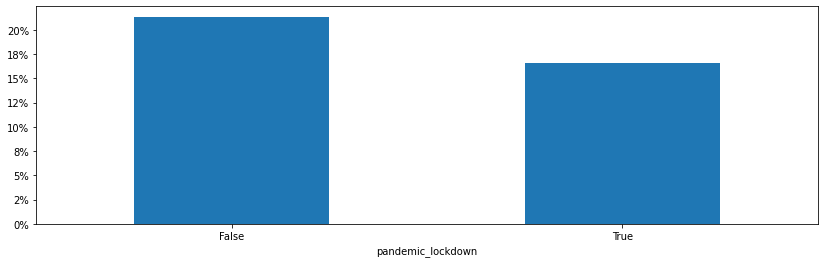

In [15]:
ax = train.groupby('pandemic_lockdown').cleared.mean().plot.bar(figsize = (14, 4))

plt.xticks(rotation = 0)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 0));

It looks like there was a lower clearance rate during the peak of stay at home orders. Let's see if this is a significant difference. We'll test the following hypothesis:

$H_0$: There is no difference in average cleared cases for crimes occurring during active COVID-19 stay at home orders and average cleared cases for crimes occurring outside of active COVID-19 stay at home orders.
<br>
$H_a$: The average cleared cases for crimes occurring during active COVID-19 stay at home orders is less than the average cleared cases for crimes occurring outside of active COVID-19 stay at home orders.

In [32]:
t_test_ind(
    train[train.pandemic_lockdown == True].cleared,
    train[train.pandemic_lockdown == False].cleared,
    alternative = 'less'
)

The t value between the two samples is -14.4 and the P-Value is 2.866643074371283e-47.
----------------------------------------------------------------------------
Since the P value is less than the alpha, we reject the null hypothesis.


### What crime types are more prevalent when pandemic lockdown was in effect?

In [40]:
train[train.pandemic_lockdown == True].crime_type.value_counts().head(10)

BURGLARY OF VEHICLE               2533
THEFT                             1742
CRIMINAL MISCHIEF                 1560
FAMILY DISTURBANCE                1544
AUTO THEFT                         987
ASSAULT W/INJURY-FAM/DATE VIOL     892
HARASSMENT                         791
BURGLARY NON RESIDENCE             681
ASSAULT WITH INJURY                587
THEFT BY SHOPLIFTING               582
Name: crime_type, dtype: int64

In [41]:
train[train.pandemic_lockdown == False].crime_type.value_counts().head(10)

BURGLARY OF VEHICLE               17132
THEFT                             14920
FAMILY DISTURBANCE                12511
CRIMINAL MISCHIEF                  9543
AUTO THEFT                         6292
ASSAULT W/INJURY-FAM/DATE VIOL     6268
THEFT BY SHOPLIFTING               5149
HARASSMENT                         5069
ASSAULT WITH INJURY                5005
DWI                                4124
Name: crime_type, dtype: int64

Interestingly there is not much difference in the top crimes for pandemic lockdown times versus non lockdown times.

### Was crime overall less prevalent during stay at home times?

In [46]:
pd.to_datetime('2020-08-26') - pd.to_datetime('2020-03-14')

Timedelta('165 days 00:00:00')

In [47]:
len(train[train.pandemic_lockdown == True]) / 165

134.61212121212122

In [48]:
4 * 365 + 1

1461

In [49]:
len(train[train.pandemic_lockdown == False]) / 1461

120.07460643394936